# Violence Detection with MobileNetV2 with GRU

This notebook trains a MobileNetV2 model with GRU for violence detection in videos.

In [26]:
import tensorflow as tf
import platform
import subprocess
import os

tf.random.set_seed(73)
TPU_INIT = False

# Uncomment the following line to disable GPU support
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Configure TensorFlow to use GPU memory efficiently
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"{len(gpus)} GPU(s) found and configured.")
    except RuntimeError as e:
        print("Error configuring GPU memory:", e)
else:
    print("No GPU found by TensorFlow.")

# Check GPU status depending on OS
system_platform = platform.system()
if system_platform in ['Linux', 'Darwin', 'Windows']:
    try:
        result = subprocess.run(["nvidia-smi"], stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
        if result.returncode == 0:
            print("nvidia-smi output:\n", result.stdout)
        else:
            print("nvidia-smi not found or no NVIDIA GPU available.")
    except FileNotFoundError:
        print("nvidia-smi not found. Make sure NVIDIA drivers are installed.")
else:
    print(f"No NVIDIA GPU check supported for platform: {system_platform}")

print("TensorFlow version:", tf.__version__)


1 GPU(s) found and configured.
nvidia-smi output:
 Thu May 29 11:40:08 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 576.28                 Driver Version: 576.28         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650 Ti   WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   47C    P8              4W /   50W |    2923MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A

In [27]:
import os
import platform
from IPython.display import clear_output
print(platform.platform())

# Helper functions for directory management
def resolve_dir(Dir):
    if not os.path.exists(Dir):
        os.mkdir(Dir)

def reset_path(Dir):
    if not os.path.exists(Dir):
        os.mkdir(Dir)
    else:
        # Remove files in the directory
        for filename in os.listdir(Dir):
            file_path = os.path.join(Dir, filename)
            try:
                if os.path.isfile(file_path):  # Remove files only
                    os.remove(file_path)
            except Exception as e:
                print(f"Error deleting file {file_path}: {e}")

# Create model directory if it doesn't exist
resolve_dir('model')

Windows-10-10.0.26100-SP0


In [28]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3577655850802978134
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2232156160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 132751769010009249
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


## Dataset Configuration

In [29]:
# Base directory of your project
PROJECT_DIR = os.path.join(os.getcwd(), 'data')  # ./data/

# Check dataset contents
print("Dataset path:", PROJECT_DIR)
print("Classes:", os.listdir(PROJECT_DIR))  # Should show ['Violence', 'NonViolence']

Dataset path: c:\Users\USER\Documents\GitHub\CCDEPLRL_PROJECT\data
Classes: ['NonViolence', 'Violence']


In [30]:
# Function to convert videos to frames
import cv2

IMG_SIZE = 224  # REDUCED from 224 to improve performance
ColorChannels = 3

def video_to_frames(video_path):
    """Extract frames from video"""
    frames = []
    vidcap = cv2.VideoCapture(video_path)
    success, image = vidcap.read()
    count = 0
    while success:
        if count % 5 == 0:  # Take every 5th frame to reduce redundancy
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            frames.append(image)
        success, image = vidcap.read()
        count += 1
    vidcap.release()
    return frames

## Load and Prepare Dataset

In [31]:

from tqdm import tqdm
import numpy as np

VideoDataDir = os.path.join(PROJECT_DIR) 

In [32]:

# from tqdm import tqdm
# import numpy as np

# VideoDataDir = os.path.join(PROJECT_DIR)  # Path to 'data'
# print('We have \n{} Violence images \n{} NonViolence images'.format(
#           len(os.listdir(os.path.join(VideoDataDir, 'Violence'))), 
#           len(os.listdir(os.path.join(VideoDataDir, 'NonViolence')))))

X_original = []
y_original = []

# # We'll process images instead of videos since we've already extracted frames
# CLASSES = ["NonViolence", "Violence"]   
# MAX_SAMPLES_PER_CLASS = 20000  # REDUCED from 1000 to lower memory usage

# for category in CLASSES:
#     path = os.path.join(VideoDataDir, category)
#     class_num = CLASSES.index(category)
#     print(f"Processing {category} images...")
    
#     files = os.listdir(path)
#     # if len(files) > MAX_SAMPLES_PER_CLASS:
#     #     files = files[:MAX_SAMPLES_PER_CLASS]
        
#     for i, img_file in enumerate(tqdm(files)):
#         img_path = os.path.join(path, img_file)
#         try:
#             img = cv2.imread(img_path)
#             if img is not None:
#                 img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
#                 X_original.append(img)
#                 y_original.append(class_num)
#         except Exception as e:
#             print(f"Error processing {img_path}: {e}")

# # Convert to numpy arrays
# X_original = np.array(X_original).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
# y_original = np.array(y_original)

# print(f"Total samples: {len(X_original)}")
# print(f"Shape of X: {X_original.shape}")
# print(f"Shape of y: {y_original.shape}")

## Split Data into Training and Testing Sets

In [33]:
# from sklearn.model_selection import StratifiedShuffleSplit

# # # Reshape X for the split
# # X_reshaped = X_original.reshape(-1, IMG_SIZE * IMG_SIZE * 3)
# # print("reshape done")
# # stratified_sample = StratifiedShuffleSplit(
# #     n_splits=1, test_size=0.2, random_state=73
# # )  # REDUCED test size from 0.3 to 0.2
# # print("stratified done")
# # for train_index, test_index in stratified_sample.split(X_reshaped, y_original):
# #     X_train, X_test = X_reshaped[train_index], X_reshaped[test_index]
# #     y_train, y_test = y_original[train_index], y_original[test_index]
# # print("looping done")
# # # Reshape back and normalize
# # X_train_nn = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 3) / 255.0
# # X_test_nn = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, 3) / 255.0



# print(f"Training set: {X_train_nn.shape}, {y_train.shape}")
# print(f"Testing set: {X_test_nn.shape}, {y_test.shape}")

In [34]:
len(X_original)

0

In [35]:
# # ALTERNATIVE B

# from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# stratified_sample = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=73)
# for train_index, test_index in stratified_sample.split(X_original, y_original):
#     X_train, X_test = X_original[train_index], X_original[test_index]
#     y_train, y_test = y_original[train_index], y_original[test_index]
    
# print("shuffling done")



# batch_size = 16  # or your preferred batch size

# datagen = ImageDataGenerator(rescale=1./255)

# train_gen = datagen.flow(
#     X_train, y_train,
#     batch_size=batch_size,
#     shuffle=True
# )
# val_gen = datagen.flow(
#     X_test, y_test,
#     batch_size=batch_size,
#     shuffle=False
# )

In [36]:
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 224
BATCH_SIZE = 16

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # 20% for validation
)

train_gen = datagen.flow_from_directory(
    directory=VideoDataDir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    directory=VideoDataDir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

Found 77028 images belonging to 2 classes.
Found 19256 images belonging to 2 classes.


In [37]:
train_gen.n

77028

In [38]:
val_gen.n

19256

## Define and Build the MobileNetV2 Model

In [39]:
import cv2
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt

from keras.layers import Input, GlobalAveragePooling2D, BatchNormalization, Dropout, Flatten, Dense
from keras.models import Model
from keras import regularizers
from keras.applications import MobileNetV2

epochs = 50  # INCREASED from 30 to allow model to converge better
kernel_regularizer = regularizers.l2(0.0005)  # INCREASED regularization

def load_layers():
    input_tensor = Input(shape=(IMG_SIZE, IMG_SIZE, ColorChannels))
    baseModel = MobileNetV2(pooling='avg',
                            include_top=False,
                            input_tensor=input_tensor,
                            alpha=0.75)  # ADDED alpha parameter to reduce model size
    
    headModel = baseModel.output
    # Add regularization and dropout to prevent overfitting
    headModel = Dropout(0.4)(headModel)  # ADDED dropout
    headModel = Dense(1, activation="sigmoid", 
                     kernel_regularizer=kernel_regularizer)(headModel)
    
    model = Model(inputs=baseModel.input, outputs=headModel)

    # Freeze base model layers
    for layer in baseModel.layers:
        layer.trainable = False

    print("Compiling model...")
    model.compile(loss="binary_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # ADJUSTED learning rate
                  metrics=["accuracy"])

    return model

model = load_layers()
model.summary()

Compiling model...
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 24  648         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 24  96          ['Conv1[0][0]']                  
                                )                                        

## Set Up Callbacks and Training Parameters

In [40]:
from keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau
import datetime

patience = 5  # INCREASED from 3 for more stable training

start_lr = 0.0001  # INCREASED from 0.00001
min_lr = 0.00001
max_lr = 0.0003   # INCREASED from 0.00005

batch_size = 32  # REDUCED from 32 to use less memory per batch

rampup_epochs = 10  # INCREASED from 5
sustain_epochs = 5  # INCREASED from 0
exp_decay = .85  # INCREASED from .8

def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr


class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if ((logs.get('accuracy')>=0.995)):  # ADJUSTED threshold
            print("\nLimits Reached cancelling training!")
            self.model.stop_training = True

end_callback = myCallback()

lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)  # Set verbose to True to monitor LR changes

early_stopping = EarlyStopping(patience=patience, monitor='val_loss',
                               mode='min', restore_best_weights=True, 
                               verbose=1, min_delta=.001)  # INCREASED min_delta

lr_plat = ReduceLROnPlateau(patience=3, mode='min', verbose=1, factor=0.7)  # ADJUSTED parameters

# Create logs directory if it doesn't exist
if not os.path.exists('./logs'):
    os.makedirs('./logs')

log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, write_graph=True, histogram_freq=1)

# Save model to the model directory
checkpoint_filepath = 'model/ModelWeights_all_224.weights.h5'
model_save_path = 'model/model_all_224.h5'

model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                    save_weights_only=True,
                                    monitor='val_loss',
                                    mode='min',
                                    verbose=1,
                                    save_best_only=True)

callbacks = [end_callback, lr_callback, model_checkpoints, tensorboard_callback, early_stopping, lr_plat]

## Train the Model

In [41]:
# print('Training model...')
# # Uncomment to load pre-trained weights if available
# # model.load_weights('./model/ModelWeights.h5')

# history = model.fit(X_train_nn, y_train, 
#                     epochs=epochs,
#                     callbacks=callbacks,
#                     validation_data=(X_test_nn, y_test),
#                     batch_size=batch_size)

# print('\nRestoring best weights...')
# model.load_weights(checkpoint_filepath)

In [42]:
# TRAIN MODEL V2

print('Training model...')
# Uncomment to load pre-trained weights if available
# model.load_weights('./model/ModelWeights.h5')

history = model.fit(train_gen,
                    epochs=epochs,
                    callbacks=callbacks,
                    validation_data=val_gen,
)

print('\nRestoring best weights...')
model.load_weights(checkpoint_filepath)

Training model...

Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/50
4815/4815 [==============================] - ETA: 0s - loss: 0.3553 - accuracy: 0.8386
Epoch 1: val_loss improved from inf to 0.24594, saving model to model\ModelWeights_all_224.weights.h5
4815/4815 [==============================] - 572s 118ms/step - loss: 0.3553 - accuracy: 0.8386 - val_loss: 0.2459 - val_accuracy: 0.9081 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.00012.
Epoch 2/50
4815/4815 [==============================] - ETA: 0s - loss: 0.2416 - accuracy: 0.9020
Epoch 2: val_loss improved from 0.24594 to 0.22071, saving model to model\ModelWeights_all_224.weights.h5
4815/4815 [==============================] - 549s 114ms/step - loss: 0.2416 - accuracy: 0.9020 - val_loss: 0.2207 - val_accuracy: 0.9169 - lr: 1.2000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.00014.
Epoch 3/50
4815/4815 [==============================] - ETA: 0s - loss: 0

## Evaluate the Model

------------------------------------------------------------------------------------------
1204/1204 [==============================] - 86s 71ms/step - loss: 0.2019 - accuracy: 0.9217
Best Epoch:  6
Accuracy on train: 0.921028733253479 	Loss on train: 0.20074962079524994
Accuracy on test: 0.9216867685317993 	Loss on test: 0.20191720128059387


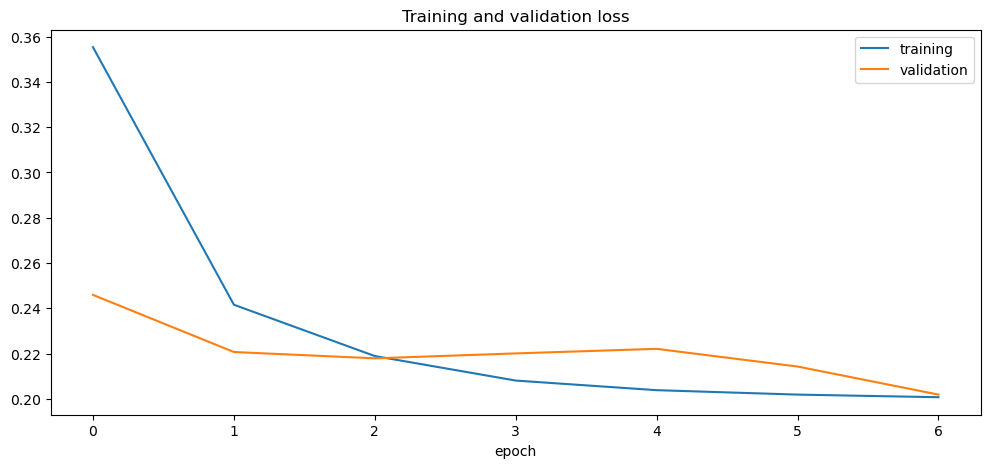

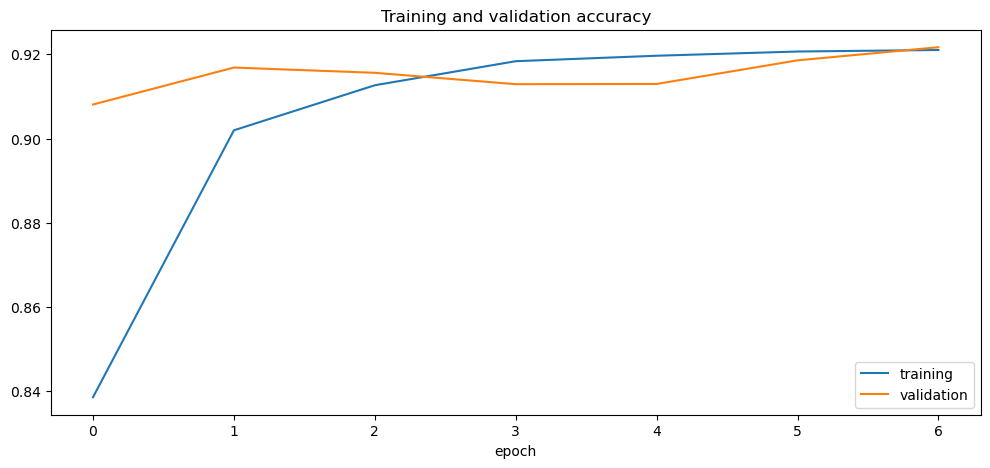

------------------------------------------------------------------------------------------


In [43]:
%matplotlib inline

def print_graph(item, index, history):
    plt.figure(figsize=(12, 5))
    train_values = history.history[item][0:index]
    plt.plot(train_values)
    test_values = history.history['val_' + item][0:index]
    plt.plot(test_values)
    plt.legend(['training','validation'])
    plt.title('Training and validation '+ item)
    plt.xlabel('epoch')
    
    # Save the plot to images directory
    if not os.path.exists('images'):
        os.makedirs('images')
    plot_path = os.path.join('images', f'{item}.png')
    plt.savefig(plot_path)
    plt.show()


def get_best_epoch(test_loss, history):
    for key, item in enumerate(history.history.items()):
        (name, arr) = item
        if name == 'val_loss':
            for i in range(len(arr)):
                if round(test_loss, 2) == round(arr[i], 2):
                    return i
    return len(history.history['val_loss']) - 1  # Return last epoch if not found
                
# def model_summary(model, history):
#     print('---'*30)
#     test_loss, test_accuracy = model.evaluate(X_test_nn, y_test, verbose=1)

#     if history:
#         index = get_best_epoch(test_loss, history)
#         print('Best Epoch: ', index)

#         train_accuracy = history.history['accuracy'][index]
#         train_loss = history.history['loss'][index]

#         print('Accuracy on train:', train_accuracy, '\tLoss on train:', train_loss)
#         print('Accuracy on test:', test_accuracy, '\tLoss on test:', test_loss)
#         print_graph('loss', index+1, history)
#         print_graph('accuracy', index+1, history)
#         print('---'*30)                

# MODEL SUMMARY V2
def model_summary(model, history):
    print('---'*30)
    test_loss, test_accuracy = model.evaluate(val_gen, verbose=1)

    if history:
        index = get_best_epoch(test_loss, history)
        print('Best Epoch: ', index)

        train_accuracy = history.history['accuracy'][index]
        train_loss = history.history['loss'][index]

        print('Accuracy on train:', train_accuracy, '\tLoss on train:', train_loss)
        print('Accuracy on test:', test_accuracy, '\tLoss on test:', test_loss)
        print_graph('loss', index+1, history)
        print_graph('accuracy', index+1, history)
        print('---'*30)                


model_summary(model, history)

## Generate Detailed Metrics

In [44]:
# import seaborn as sns
# from sklearn import metrics
# from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, classification_report, confusion_matrix

# # Evaluate the network
# print("Evaluating network...")
# # predictions = model.predict(X_test_nn)



# # PREDICTION V2
# predictions = model.predict(val_gen)

# preds = predictions > 0.5

# # Confusion matrix
# corr_pred = metrics.confusion_matrix(y_test, preds)

# n_correct = np.int_((corr_pred[0][0] + corr_pred[1][1]))
# print('> Correct Predictions:', n_correct)
# n_wrongs = np.int_((corr_pred[0][1] + (corr_pred[1][0])))
# print('> Wrong Predictions:', n_wrongs)

# plt.figure(figsize=(8, 6))
# sns.heatmap(corr_pred, annot=True, fmt="d", cmap="Blues")
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix')

# # Save confusion matrix to images directory
# if not os.path.exists('images'):
#     os.makedirs('images')
# plt.savefig('images/confusion_matrix.png')
# plt.show()

# # Classification report
# print(metrics.classification_report(y_test, preds, 
#                            target_names=["NonViolence", "Violence"]))

Evaluating network...
1204/1204 [==============================] - 97s 79ms/step
> Correct Predictions: 17748
> Wrong Predictions: 1508


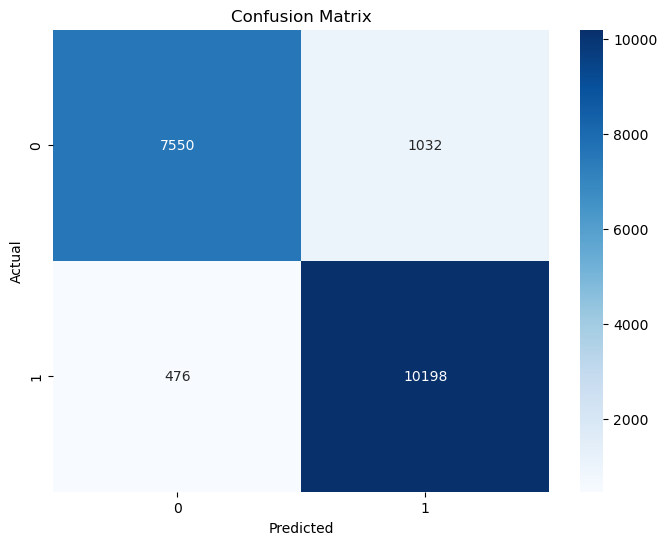

              precision    recall  f1-score   support

 NonViolence       0.94      0.88      0.91      8582
    Violence       0.91      0.96      0.93     10674

    accuracy                           0.92     19256
   macro avg       0.92      0.92      0.92     19256
weighted avg       0.92      0.92      0.92     19256



In [45]:
import seaborn as sns
from sklearn import metrics
import numpy as np

print("Evaluating network...")

# Get predictions for the entire validation set
predictions = model.predict(val_gen)
preds = predictions > 0.5

# Get true labels from the generator
true_labels = []
for i in range(len(val_gen)):
    _, labels = val_gen[i]
    true_labels.extend(labels)
true_labels = np.array(true_labels)
true_labels = true_labels[:len(preds)]  # In case the last batch is smaller

# Confusion matrix
corr_pred = metrics.confusion_matrix(true_labels, preds)

n_correct = int((corr_pred[0][0] + corr_pred[1][1]))
print('> Correct Predictions:', n_correct)
n_wrongs = int((corr_pred[0][1] + corr_pred[1][0]))
print('> Wrong Predictions:', n_wrongs)

plt.figure(figsize=(8, 6))
sns.heatmap(corr_pred, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

if not os.path.exists('images'):
    os.makedirs('images')
plt.savefig('images/confusion_matrix.png')
plt.show()

# Classification report
print(metrics.classification_report(true_labels, preds, 
                           target_names=["NonViolence", "Violence"]))

## Save the Full Model in h5 and tflite

In [46]:
import tensorflow as tf

# Save the full model to the model directory
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the .tflite model
with open('model/violence_model_all_224.tflite', 'wb') as f:
    f.write(tflite_model)

Model saved to model/model_all_224.h5


INFO:tensorflow:Assets written to: C:\Users\USER\AppData\Local\Temp\tmpr49334e_\assets


INFO:tensorflow:Assets written to: C:\Users\USER\AppData\Local\Temp\tmpr49334e_\assets


## Test Prediction on a Sample Video

Model loaded successfully!
Testing on sample video: video/Violence/V_79.mp4
1/1 [==============================] - 1s 772ms/step
Violence probability: 0.7763
Prediction: Violence


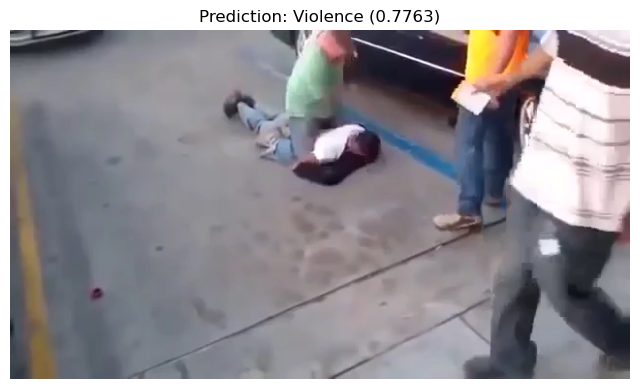

In [47]:
# Load the model and test on a sample video frame
from keras.models import load_model
import numpy as np
import cv2

# Test model loading
test_model = load_model(model_save_path)
print("Model loaded successfully!")

# Test on a sample video frame if available
try:
    # Try to find a sample violence video
    sample_video_path = "video/Violence/V_79.mp4"
    if not os.path.exists(sample_video_path):
        sample_video_path = None
        for root, dirs, files in os.walk("video"):
            for file in files:
                if file.endswith(".mp4"):
                    sample_video_path = os.path.join(root, file)
                    break
            if sample_video_path:
                break
    
    if sample_video_path:
        print(f"Testing on sample video: {sample_video_path}")
        cap = cv2.VideoCapture(sample_video_path)
        ret, frame = cap.read()
        if ret:
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame_resized = cv2.resize(frame_rgb, (IMG_SIZE, IMG_SIZE))
            frame_normalized = frame_resized.astype("float32") / 255.0
            
            # Make prediction
            prediction = test_model.predict(np.expand_dims(frame_normalized, axis=0))[0][0]
            print(f"Violence probability: {prediction:.4f}")
            print(f"Prediction: {'Violence' if prediction > 0.5 else 'NonViolence'}")
            
            # Display the frame
            plt.figure(figsize=(8, 8))
            plt.imshow(frame_rgb)
            plt.title(f"Prediction: {'Violence' if prediction > 0.5 else 'NonViolence'} ({prediction:.4f})")
            plt.axis('off')
            plt.show()
        else:
            print("Failed to read frame from video.")
        cap.release()
    else:
        print("No sample video found for testing.")
except Exception as e:
    print(f"Error during sample prediction: {e}")